In [4]:
#mount GDrive
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [6]:
import os

os.chdir("/content/gdrive/My Drive/data/hershey_data")

In [7]:
import pickle as pic
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import SGD
from tensorflow.keras.utils import Sequence


In [8]:
#data generator
def data_gen(file_list,batch_size):

    while True:
        for file in file_list:
            #load data
            data = pic.load(open(file,'rb'),encoding="bytes")
            cur_len = len(data['sG_data'])
            for i in range(0,cur_len,batch_size):
                x = data['sG_data'][i:i+batch_size]
                y = data['sG_labels'][i:i+batch_size]
                yield x,y
                x = []
                y = []

In [9]:
no_files = 2
files_train = ["data_batch_"+i.__str__() for i in range(no_files)] #two files
total_len = 0
# get total sample length of two files
for file in files_train:
  total_len += len(pic.load(open(file,'rb'),encoding="bytes")['sG_data'])

In [22]:
#residual module
def res_module(inp):
    if not inp.shape[-1] == 64:
        #project with 1x1 convolution
        inp = Conv2D(64,1,activation="relu")(inp)
    x = BatchNormalization()(inp)
    x = Activation("relu")(x)
    x = Conv2D(16, 3,padding="same",activation="sigmoid")(x)
    x = Conv2D(32, 3,padding="same",activation="sigmoid")(x)
    x = Conv2D(64, 3,padding="same",activation="sigmoid")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(16, 3,padding="same",activation="sigmoid")(x)
    x = Conv2D(32, 3,padding="same",activation="sigmoid")(x)
    x = Conv2D(64, 3,padding="same",activation="sigmoid")(x)
    out = add([x, inp])
    return out

#two block res module
inp = Input(shape=(95, 60, 4))
x_a = res_module(inp)
x_a = res_module(x_a)
x_a = res_module(x_a)
x_a = res_module(x_a)
x_a = MaxPooling2D(7)(x_a)
x_a = Flatten()(x_a)
out = Dense(5700,activation='softmax')(x_a)
# create model
model = Model(inputs=inp, outputs=out)
# summarize model
model.summary()


Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 95, 60, 4)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 95, 60, 64)   320         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 95, 60, 64)   256         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_8 (Activation)       (None, 95, 60, 64)   0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
# data_gen_obj = data_gen(files_train, 64, total_len)
history = model.fit(data_gen(files_train,100),steps_per_epoch=total_len // 100,epochs=1)

30/30 [==============================] - 9s 290ms/step - loss: 0.1216 - accuracy: 0.9810


In [30]:
x,y = next(data_gen(files_train,100))
pred_img = model.predict(x)
actual_imgs = y

In [31]:
for pred,img in zip(pred_img,actual_imgs):
  print("predicted : ",np.argmax(pred),"actual : ",np.argmax(img),"pred : ",pred[np.argmax(pred)]," actual : ",img[np.argmax(img)])


predicted :  3453 actual :  3453 pred :  0.94237226  actual :  1.0
predicted :  2318 actual :  2318 pred :  0.3487612  actual :  1.0
predicted :  3219 actual :  3219 pred :  0.99923074  actual :  1.0
predicted :  2909 actual :  2909 pred :  0.9804081  actual :  1.0
predicted :  2790 actual :  2790 pred :  0.930958  actual :  1.0
predicted :  2377 actual :  2377 pred :  0.9694047  actual :  1.0
predicted :  2558 actual :  2558 pred :  0.8607203  actual :  1.0
predicted :  2318 actual :  2318 pred :  0.92120266  actual :  1.0
predicted :  3455 actual :  3455 pred :  0.9835032  actual :  1.0
predicted :  2736 actual :  2736 pred :  0.633538  actual :  1.0
predicted :  2796 actual :  2796 pred :  0.897684  actual :  1.0
predicted :  3393 actual :  3393 pred :  0.80248106  actual :  1.0
predicted :  3453 actual :  3453 pred :  0.9632157  actual :  1.0
predicted :  2440 actual :  2440 pred :  0.8535797  actual :  1.0
predicted :  2435 actual :  2435 pred :  0.75446314  actual :  1.0
predicte

In [32]:
#plotting history object 
import matplotlib.pyplot as plt

print(history.history.keys())

dict_keys(['loss', 'accuracy'])


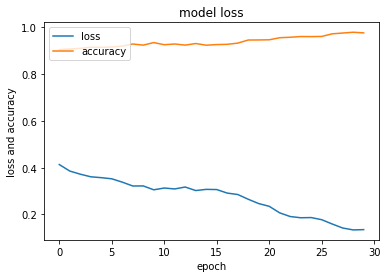

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss and accuracy')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()